<a href="https://colab.research.google.com/github/Amarnath-188/Design-Optimization/blob/Project-1/Inverted_pendulum_MPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Introduction**

This inverted pendulum thing on a cart that can move back and forth. The challenge is to create a smart controller, using something called Model Predictive Control (MPC), to guide the cart. The goal is to make the cart go from a starting point at  y = -1.0  to  y = 0.0  in just 8 seconds. And, here's the catch – we want to double-check that the speed of the cart v , the tilt of the pendulum  $\theta$, and this adjustable cart thing  q  are all at zero both before and after the move. This MPC thing is cool because it predicts how the system will behave and adjusts the controls accordingly. Basically, it's like teaching the system to do a dance to get from point A to point B without falling over, and we want it to nail the routine in under 6.2 seconds. Oh, and make sure everything's calm and at rest when it's done.


# **Here's a breakdown of the key components:**

1. **System Description**: The system consists of an inverted pendulum mounted on an adjustable cart. The cart can move horizontally along a track, and the objective is to control the motion of the cart in such a way that the pendulum remains stable in an upright position.

2. **Controller Type**: Model Predictive Control (MPC) is the chosen control strategy. MPC is an advanced control technique that uses a dynamic model of the system to predict its future behavior and optimize control inputs over a finite time horizon.

3. **Maneuver Requirements**: The cart needs to execute a sequence of moves that result in its position changing from  y = -1.0  to  y = 0.0 within 6.2 seconds. This implies the need for a carefully tuned control strategy that considers the dynamics of the system and the time constraints.

4. **Parameter Verification**: Before and after the maneuver, it is essential to verify that certain parameters are zero. This includes the velocity of the cart  v , the angle of the pendulum $\theta$, and the adjustable parameter for the cart q. Ensuring these parameters are zero ensures the stability and desired state of the system.

5. **Time Constraint**: The maneuver must be completed within a specific time frame 8 seconds, adding a temporal aspect to the control problem.

In summary, the problem involves designing a Model Predictive Controller to control the motion of an inverted pendulum system with an adjustable cart. The controller should be capable of executing a predefined sequence of moves to transition the cart from one position to another within a specified time, while ensuring the stability of the system by verifying key parameters before and after the maneuver.



Dynamics for Inverted Pendulum:

$\dot{y} = v$

$\dot{v} = -\epsilon \theta + u$

$\dot{\theta} = q$

$\dot{q} = \theta - u$

This can be written in $\dot{X} = AX + B u$



$y$ - position of the cart

$u$ - Applied force on the cart

$\theta$ - Angle of the pendulum reference to the cart

$\epsilon$ - mass fraction - $\frac{m_2}{m_1+m_2}$

$q$ - Rate of anglular change of $\theta$



Adjust the controller settings to minimize the force exerted on the cart, whether moving forward or backward. This involves fine-tuning the controller parameters with the aim of reducing the overall energy or fuel consumption required to execute the maneuver effectively.

In Model Predictive Control (MPC), this adjustment involves optimizing the predictive model to achieve the desired outcome while minimizing the energy input. The controller anticipates the system's future behavior and adjusts the control inputs at each step to achieve the optimal trajectory with the least amount of force applied to the cart. By emphasizing the reduction of force or energy consumption, this tuning approach aligns with the goal of achieving maneuverability while prioritizing efficiency and resource conservation.

In [1]:
pip install gekko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 73.9 MB/s eta 0:00:00


In [5]:
import matplotlib.animation as animation
import numpy as np
from gekko import GEKKO
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [35]:
# Define a control system model
model = GEKKO()

# Weight of the item
item_weight = 20

# Define the time, going beyond 6.2s
model.time = np.linspace(0, 10, 100)
end_location = int(100.0 * 8 / 10.0)

# Parameters
m1_value = 10
m2_value = item_weight

final = np.zeros(len(model.time))
for i in range(len(model.time)):
    if model.time[i] < 8:
        final[i] = 0
    else:
        final[i] = 1
final = model.Param(value=final)

# Manipulated variable
u = model.Var(value=0)

# State variables
theta = model.Var(value=0)
q = model.Var(value=0)
y = model.Var(value=-1)
v = model.Var(value=0)

# Intermediates
epsilon = model.Intermediate(m2_value / (m1_value + m2_value))

# State Space Model
model.Equation(y.dt() == v)
model.Equation(v.dt() == -epsilon * theta + u)
model.Equation(theta.dt() == q)
model.Equation(q.dt() == theta - u)

# Objectives_Definatiom
model.Obj(final * y**2)
model.Obj(final * v**2)
model.Obj(final * theta**2)
model.Obj(final * q**2)

model.fix(y, pos=end_location, val=0.0)
model.fix(v, pos=end_location, val=0.0)
model.fix(theta, pos=end_location, val=0.0)
model.fix(q, pos=end_location, val=0.0)

# Minimize change of manipulated variable over the horizon
model.Obj(0.001 * u**2)

model.options.IMODE = 6  # MPC
model.solve(disp=True);

apm 35.221.39.71_gk_model17 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :            6
   Intermediates:            1
   Connections  :            8
   Equations    :           10
   Residuals    :            9
 
 Number of state variables:            883
 Number of total equations: -          792
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             91
 
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program contains Ipop

**Plotting & Animation**

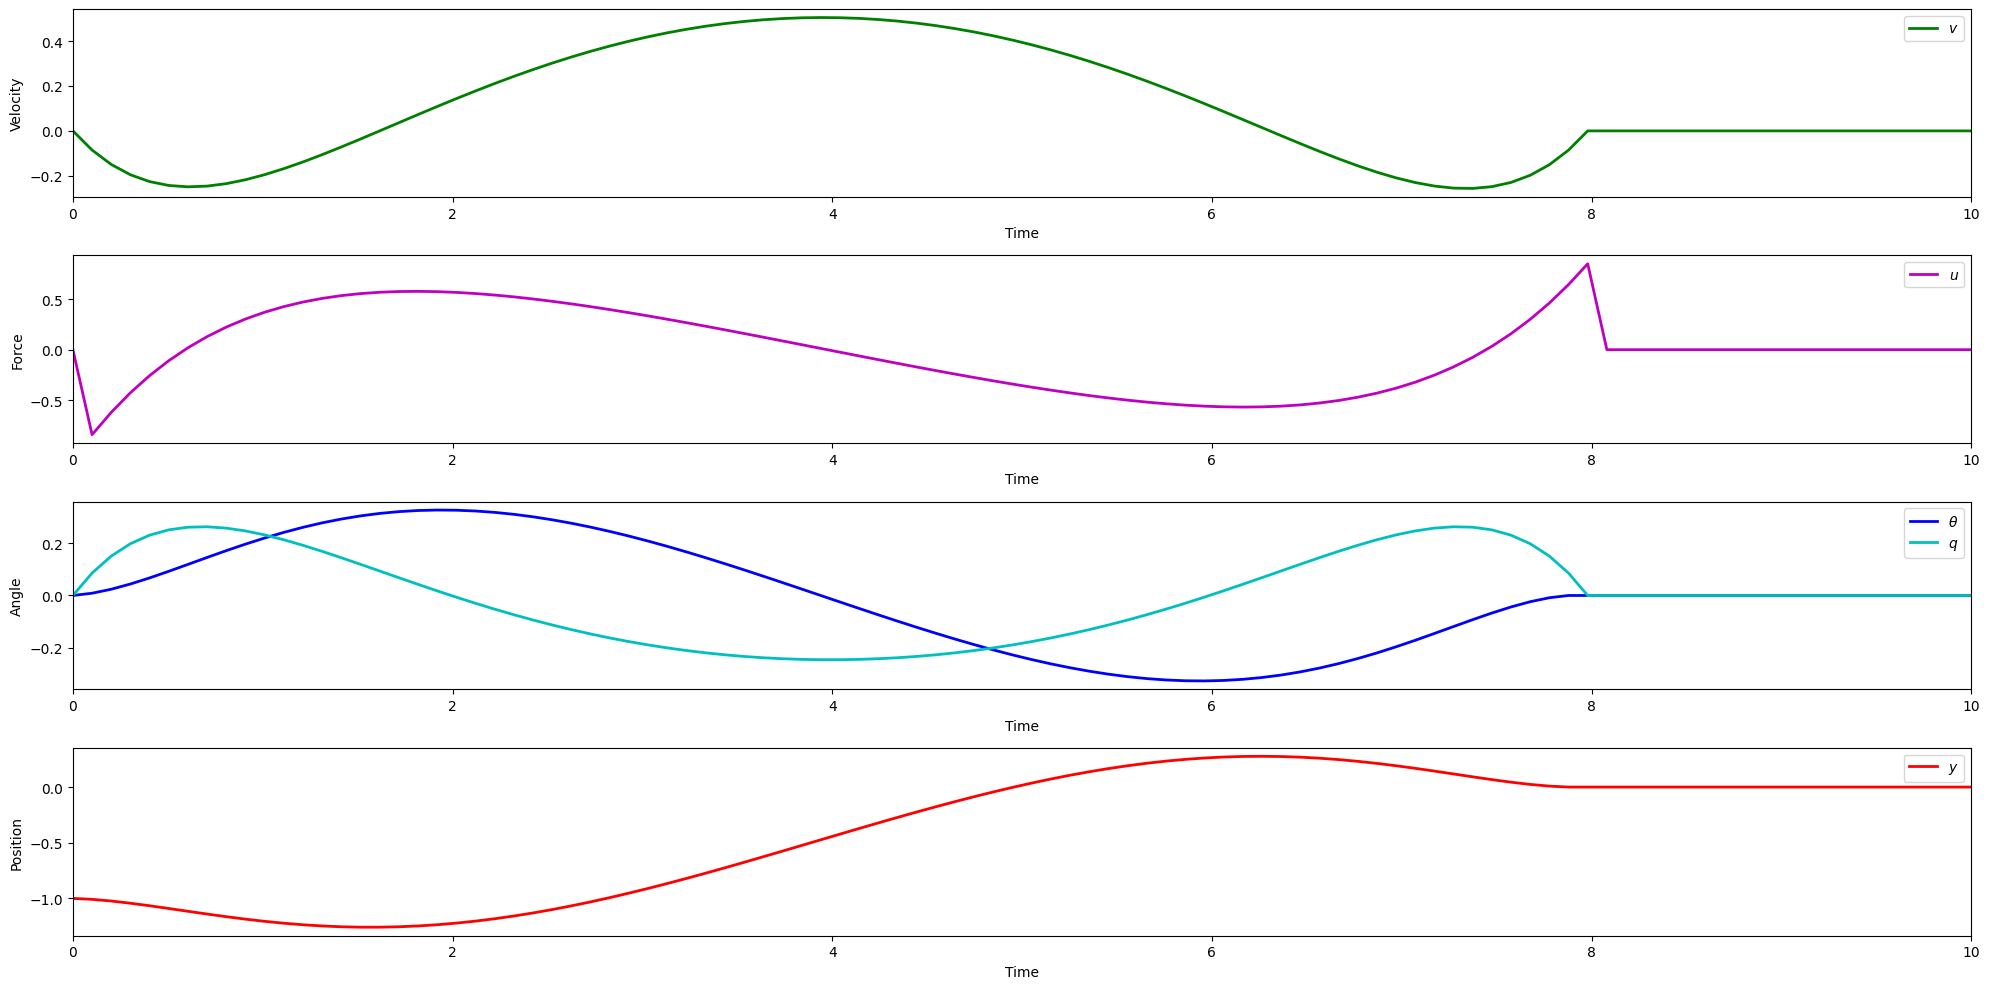

<Figure size 640x480 with 0 Axes>

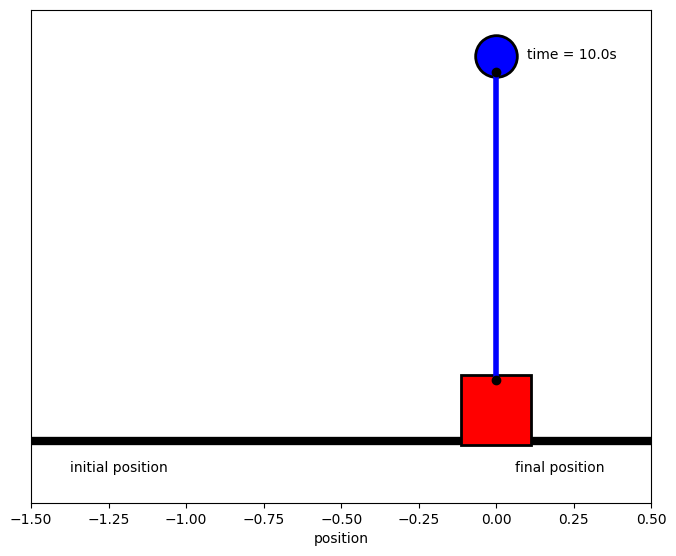

In [37]:
fig1 = plt.figure(figsize=(20, 10))

# Velocity_Plot
ax1 = fig1.add_subplot(411)
ax1.plot(model.time, v.value, 'g', lw=2, label=r'$v$')
ax1.legend(loc=1)
ax1.set_ylabel('Velocity')
ax1.set_xlabel('Time')
ax1.set_xlim(model.time[0], model.time[-1])

# Control input_Plot
ax2 = fig1.add_subplot(412)
ax2.plot(model.time, u.value, 'm', lw=2, label=r'$u$')
ax2.legend(loc=1)
ax2.set_ylabel('Force')
ax2.set_xlabel('Time')
ax2.set_xlim(model.time[0], model.time[-1])

# Angle_&_Angular velocity_Plot
ax3 = fig1.add_subplot(413)
ax3.plot(model.time, theta.value, 'b', lw=2, label=r'$\theta$')
ax3.plot(model.time, q.value, 'c', lw=2, label=r'$q$')
ax3.legend(loc=1)
ax3.set_ylabel('Angle')
ax3.set_xlabel('Time')
ax3.set_xlim(model.time[0], model.time[-1])

# Position_Plot
ax4 = fig1.add_subplot(414)
ax4.plot(model.time, y.value, 'r', lw=2, label=r'$y$')
ax4.legend(loc=1)
ax4.set_ylabel('Position')
ax4.set_xlabel('Time')
ax4.set_xlim(model.time[0], model.time[-1])

plt.tight_layout()
plt.show()

# Layout_Setup
plt.tight_layout()

# Setup_Animation
x1 = y.value
y1 = np.zeros(len(model.time))
x2 = 1 * np.sin(theta.value) + x1
x2b = 1.05 * np.sin(theta.value) + x1
y2 = 1 * np.cos(theta.value) - y1
y2b = 1.05 * np.cos(theta.value) - y1

# Animation
fig_anim, ax_anim = plt.subplots(figsize=(8, 6.4))
ax_anim.set_xlim(-1.5, 0.5)
ax_anim.set_ylim(-0.4, 1.2)
ax_anim.set_xlabel('position')
ax_anim.get_yaxis().set_visible(False)
crane_rail, = ax_anim.plot([-1.5, 0.5], [-0.2, -0.2], 'k-', lw=6)
mass1_point, = ax_anim.plot([], [], linestyle='None', marker='s',
                            markersize=50, markeredgecolor='k',
                            color='red', markeredgewidth=2)
mass2_point, = ax_anim.plot([], [], linestyle='None', marker='o',
                            markersize=30, markeredgecolor='k',
                            color='blue', markeredgewidth=2)
line_anim, = ax_anim.plot([], [], 'o-', color='blue', lw=4,
                         markersize=6, markeredgecolor='k',
                         markerfacecolor='k')
time_template = 'time = %.1fs'
time_text = ax_anim.text(0.8, 0.9, '', transform=ax_anim.transAxes)
start_text = ax_anim.text(-1.06, -0.3, 'initial position', ha='right')
end_text = ax_anim.text(0.06, -0.3, 'final position', ha='left')


def init_anim():
    mass1_point.set_data([], [])
    mass2_point.set_data([], [])
    line_anim.set_data([], [])
    time_text.set_text('')
    return line_anim, mass1_point, mass2_point, time_text


def animate_frames(i):
    mass1_point.set_data([x1[i]], [y1[i] - 0.1])
    mass2_point.set_data([x2b[i]], [y2b[i]])
    line_anim.set_data([x1[i], x2[i]], [y1[i], y2[i]])
    time_text.set_text(time_template % model.time[i])
    return line_anim, mass1_point, mass2_point, time_text


ani_frames = animation.FuncAnimation(fig_anim, animate_frames,
                                     np.arange(1, len(model.time)),
                                     interval=40, blit=False, init_func=init_anim)

ani_frames.save('Inverted_Pendulum_MPC.mp4', fps=30)

plt.show()

#**Overlapping all the data**#

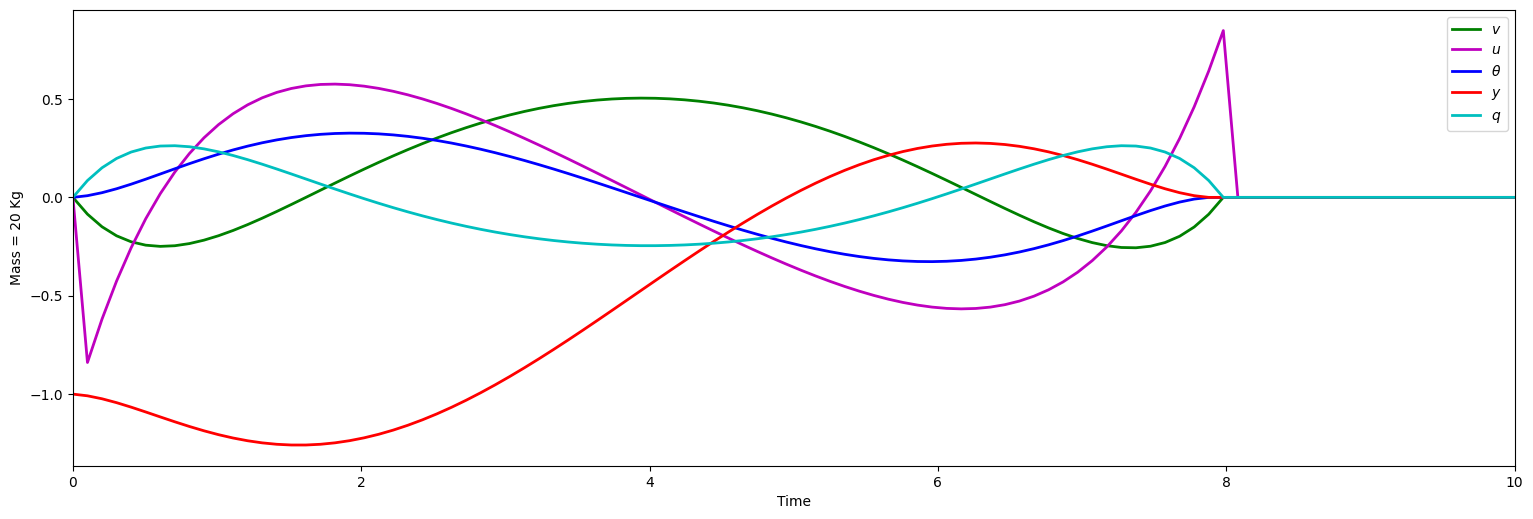

In [21]:
fig2 = plt.figure(figsize=(30, 10))

# Velocity_Plot
ax1 = fig2.add_subplot(221)
ax1.plot(model.time, v.value, 'g', lw=2, label=r'$v$')
ax1.plot(model.time, u.value, 'm', lw=2, label=r'$u$')
ax1.plot(model.time, theta.value, 'b', lw=2, label=r'$\theta$')
ax1.plot(model.time, y.value, 'r', lw=2, label=r'$y$')
ax1.plot(model.time, q.value, 'c', lw=2, label=r'$q$')
ax1.legend(loc=1)
ax1.set_ylabel('Mass = 20 Kg')
ax1.set_xlabel('Time')
ax1.set_xlim(model.time[0], model.time[-1])
plt.legend(loc=1)
plt.tight_layout()
plt.show()

#**Mass with Variable weights**#

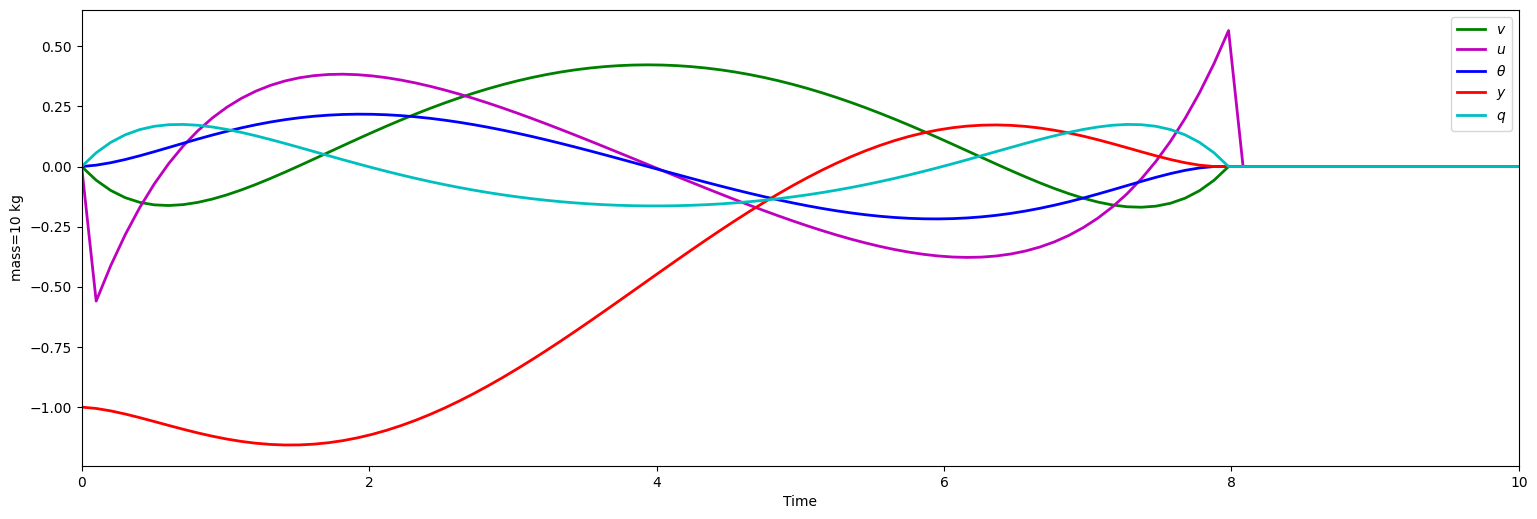

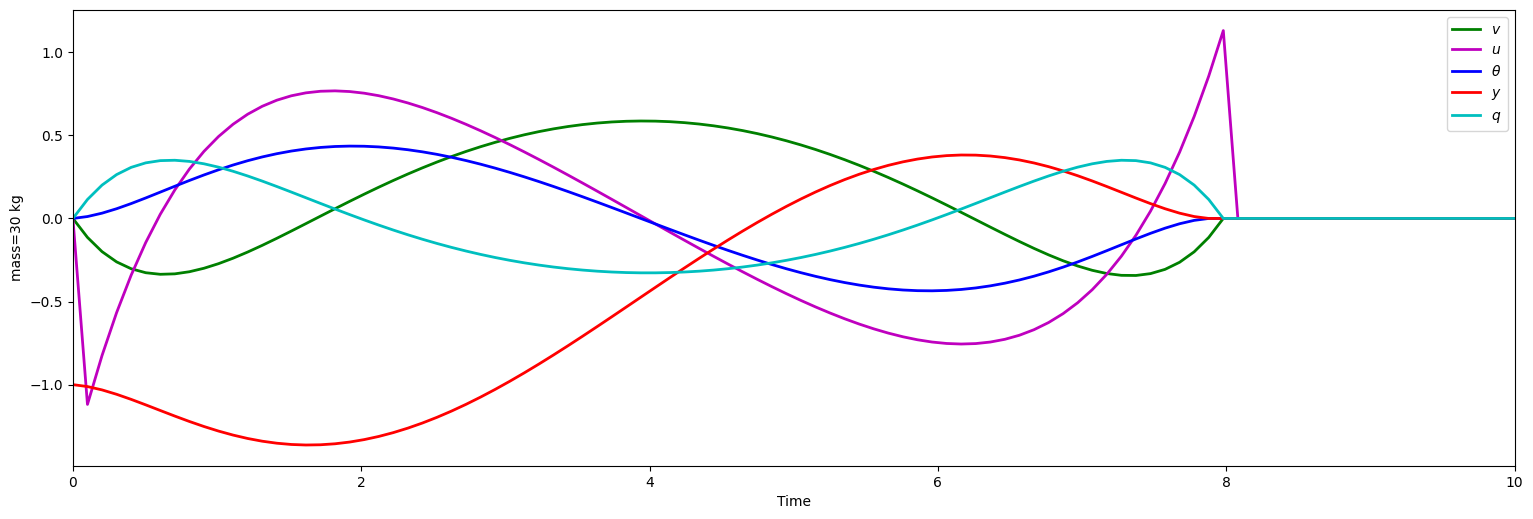

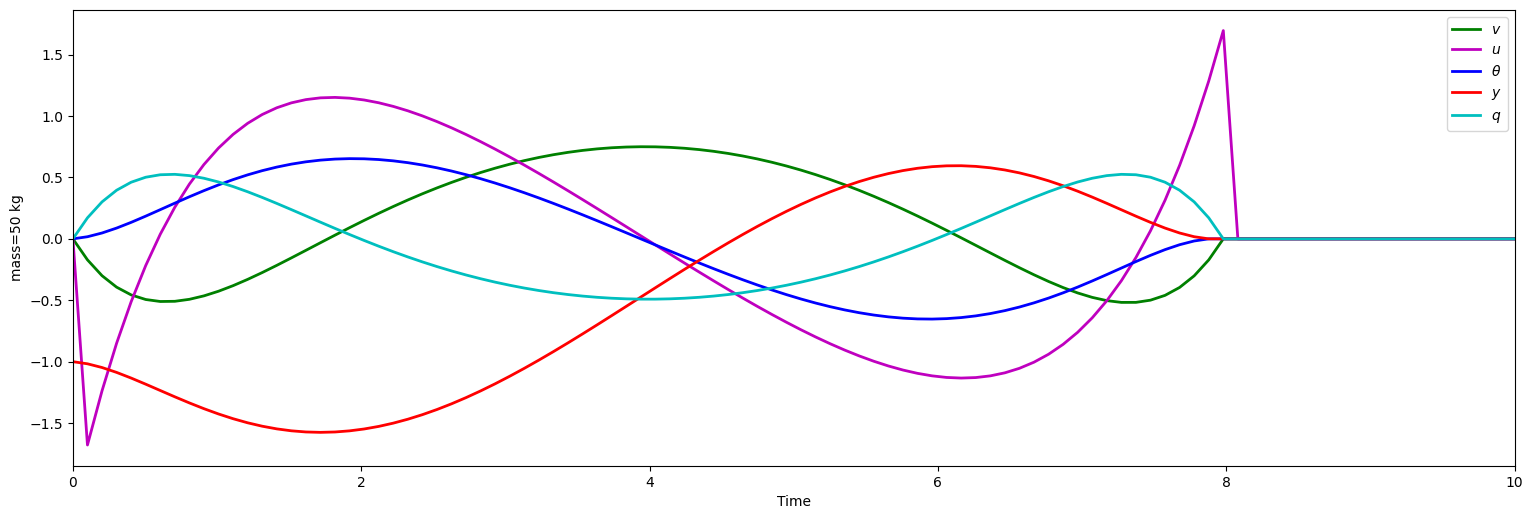

In [34]:
mass = [10,30,50]
nm = len(mass)

for j in range(len(mass)):
    m1 = 10
    m2 = mass[j]

    # Define a control system model
    model = GEKKO()

    # Weight of the item
    item_weight = mass[j]

    # Define the time, going beyond 6.2s
    model.time = np.linspace(0, 10, 100)
    end_location = int(100.0 * 8 / 10.0)

    # Parameters
    m1_value = 10
    m2_value = item_weight

    final = np.zeros(len(model.time))
    for i in range(len(model.time)):
        if model.time[i] < 8:
            final[i] = 0
        else:
            final[i] = 1
    final = model.Param(value=final)

    # Manipulated variable
    u = model.Var(value=0)

    # State variables
    theta = model.Var(value=0)
    q = model.Var(value=0)
    y = model.Var(value=-1)
    v = model.Var(value=0)

    # Intermediates
    epsilon = model.Intermediate(m2_value / (m1_value + m2_value))

    # State Space Model
    model.Equation(y.dt() == v)
    model.Equation(v.dt() == -epsilon * theta + u)
    model.Equation(theta.dt() == q)
    model.Equation(q.dt() == theta - u)

    # Objectives_Definatiom
    model.Obj(final * y**2)
    model.Obj(final * v**2)
    model.Obj(final * theta**2)
    model.Obj(final * q**2)

    model.fix(y, pos=end_location, val=0.0)
    model.fix(v, pos=end_location, val=0.0)
    model.fix(theta, pos=end_location, val=0.0)
    model.fix(q, pos=end_location, val=0.0)

    # Minimize change of manipulated variable over the horizon
    model.Obj(0.001 * u**2)

    model.options.IMODE = 6  # MPC
    model.solve(disp=False);

    fig2 = plt.figure(figsize=(30, 10))

    # Velocity_Plot
    ax1 = fig2.add_subplot(221)
    ax1.plot(model.time, v.value, 'g', lw=2, label=r'$v$')
    ax1.plot(model.time, u.value, 'm', lw=2, label=r'$u$')
    ax1.plot(model.time, theta.value, 'b', lw=2, label=r'$\theta$')
    ax1.plot(model.time, y.value, 'r', lw=2, label=r'$y$')
    ax1.plot(model.time, q.value, 'c', lw=2, label=r'$q$')
    ax1.legend(loc=1)
    ax1.set_ylabel(f'mass={mass[j]} kg')
    ax1.set_xlabel('Time')
    ax1.set_xlim(model.time[0], model.time[-1])
    plt.legend(loc=1)
    plt.tight_layout()
    plt.show()



**Remarks:**

The final time to control and the final location has not been changed for the variable mass condition.



*   Over-shooting of the mass is increasing with increase in mass
*   u velocity spikes at initail as well as at the  destination and its magnitude in increased for increase in mass
* All other parameters follow sinusoidal curve with increase in magnitude in both the extreme ends with increase in mass


